# ChatGPT analysis

## Initialize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hiron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hiron\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



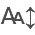

In [2]:
import os
from dotenv import load_dotenv

import re
from datetime import date,timedelta
import time
import csv
import os

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import random

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter

import multiprocessing
from multiprocessing import Manager
import importlib 

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

from openai import OpenAI

import pickle
from pandas import option_context

In [6]:
#PARAMETERS

# Source folder to fetch source article files
SOURCE_FOLDER = 'data/'

# Filter prefix used when fetching files
FILE_PREFIX = 'articles_'

# POS filter to only keep relevant POS (part of speech) terms
POS_FILTER = set(['CC','DT','IN','JJ','JJR','JJS','MD','PDT','PRP','PRP$','RB','RBR','RBS','RP','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WRB'])

# Chat GPT prompt used when calling chatGPT for text editting
prompt = "Please edit the following paragraphs to sound more refined for a blog post.\r\n\r\n"

# output file name after calling chatgpt
output_file = 'data/chatgpt.csv'

## ChatGPT call

In [44]:
#Fetch files and content and read into a dataframe
files = os.listdir(None if SOURCE_FOLDER == ''  else SOURCE_FOLDER)

target_sources = []
source_df = None

for file in files:
    if file.startswith(FILE_PREFIX):
        target_sources.append(file)
for source in target_sources:
    if source_df is None:
        source_df = pd.read_csv(SOURCE_FOLDER + source)
    else:
        source_df = pd.concat([source_df,pd.read_csv(SOURCE_FOLDER + source)], axis=0)

source_df = source_df.reset_index()
source_df = source_df.rename(columns={'content': 'content orig'})
source_df['content mod'] = ""


In [ ]:
#Filter the source dataframe articles as needed. This is done to reduce # of chatGPT calls
#source_df = source_df.loc[source_df['date'].str.contains('2022-01'),:]


In [ ]:
# Actual chatGPT call
%%time

def modify_with_chatgpt(content):
    """Calls chatGPT with the included prompt and the article content 
    """
    content = "Please edit the following paragraphs to sound more refined for a blog post.\r\n\r\n" + content
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "user", "content": content}
      ]
    )
    return completion.choices[0].message.content

# For each call, write it to the output file. 
# Note that the output file is set as "append", so accidental data loss won't occur (in exchange of potential duplicates when rerunning the script
with open(output_file, "a",encoding="utf-8") as file:
    writer = csv.writer(file, dialect='excel')
    if (os.path.getsize(output_file) == 0):
        writer.writerow(['index','url','tag','date','content orig', 'content mod'])
    for index,row in source_df.iterrows():
        modified_content = modify_with_chatgpt(row['content orig'])
        row['content mod'] = modified_content
        writer.writerow(row)
    file.close()

## POS tagging

In [7]:
# If reading the chatGPT results from a CSV, uncomment the following line
source_df = pd.read_csv(output_file)

In [9]:
%%time

#workers2.py holds the actual POS tagging script. Creating a separate python file so it can be done as a multi-process
import workers2
importlib.reload(workers2)


articles_stats = pd.DataFrame(columns=['url','sentence count orig','word count orig', 'sentence count mod', 'word count mod'])
word_stats = pd.DataFrame(columns=['word','pos','word count orig', 'word count mod'])



if __name__ == '__main__':
    pool = multiprocessing.Pool()
    word_counter_orig = Counter([("","")])
    word_counter_mod = Counter([("","")])
    results = pool.map(workers2.count_words_2,[(row,POS_FILTER) for index, row in source_df.iterrows()])
    for counter_orig, counter_mod, article_stats in results:
        word_counter_orig += counter_orig
        word_counter_mod += counter_mod
        articles_stats = pd.concat([articles_stats,article_stats],axis=0)
    words = []
    for key, value in word_counter_orig.items():
        words.append([key[0],key[1],value,word_counter_mod[(key[0],key[1])]])

    words_df = pd.DataFrame(words)
    words_df = words_df.rename({0:'word',1:'pos',2:'word count orig',3:'word count mod'},axis=1)
    pool.close()


CPU times: total: 45 s
Wall time: 3min 15s


## Frequency changes in top 1000 words by POS type

In [11]:
# Chagne the following variable to analyze different POS types
# For list of POS tags, see https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
pos_filter = 'JJ'


top_1000_words = words_df
top_1000_words['word count avg'] = (top_1000_words['word count mod'] + top_1000_words['word count orig']) / 2

top_1000_words = top_1000_words.loc[words_df['pos'].str.contains(pos_filter),:].groupby('word')['word count mod'].sum().sort_values(ascending=False).head(1000).index.to_list()
top_1000_words_df = words_df.loc[words_df['word'].isin(top_1000_words) & (words_df['pos'].str.contains(pos_filter)),:]
top_1000_words_df = top_1000_words_df.fillna(0)

In [12]:
top_1000_words_df.head(30)

word  pos  word count orig  word count mod  word count avg
18             first   JJ             9083            1595          5339.0
26          previous   JJ             3242            1067          2154.5
47              user   JJ              906            1043           974.5
68          simplest  JJS              314              51           182.5
70           maximum   JJ              916             269           592.5
...              ...  ...              ...             ...             ...
90066   enlightening   JJ                4              56            30.0
90428         latter  JJR                1               0             0.5
95862            web  JJS                1               1             1.0
99977     unwavering   JJ                1              95            48.0
101473        remote  JJR                1               0             0.5

[1049 rows x 5 columns]

In [13]:
#Create basic stats of the articles to be used for normalization

agg_funcs = {'sentence count orig': 'sum', 'sentence count mod' : 'sum','word count orig': 'sum', 'word count mod':'sum', 'url': 'count'}

basic_stats = pd.DataFrame(articles_stats.agg(agg_funcs)).transpose()
basic_stats['word per sentence orig'] = basic_stats['word count orig'] / basic_stats['sentence count orig']
basic_stats['word per sentence mod'] = basic_stats['word count mod'] / basic_stats['sentence count mod']

In [14]:
basic_stats 

sentence count orig  sentence count mod  word count orig  word count mod  \
0               449279              181867         10904978         4374098   

     url  word per sentence orig  word per sentence mod  
0  10926               24.272174              24.051081

In [15]:
#Normalizing the word count to word percentage by looking at number of sentences

top_1000_words_pct_df = top_1000_words_df[['word','word count orig','word count mod']].copy()
top_1000_words_pct_df['word pct orig'] = top_1000_words_pct_df['word count orig'] / basic_stats['url'].to_list()
top_1000_words_pct_df['word pct mod'] = top_1000_words_pct_df['word count mod'] / basic_stats['url'].to_list()



In [16]:
top_1000_words_pct_df

word  word count orig  word count mod  word pct orig  \
18             first             9083            1595       0.831320   
26          previous             3242            1067       0.296723   
47              user              906            1043       0.082921   
68          simplest              314              51       0.028739   
70           maximum              916             269       0.083837   
...              ...              ...             ...            ...   
90066   enlightening                4              56       0.000366   
90428         latter                1               0       0.000092   
95862            web                1               1       0.000092   
99977     unwavering                1              95       0.000092   
101473        remote                1               0       0.000092   

        word pct mod  
18          0.145982  
26          0.097657  
47          0.095460  
68          0.004668  
70          0.024620  
...              ...  
90066       0.005125  
90428       0.000000  
95862       0.000092  
99977       0.008695  
101473      0.000000  

[1049 rows x 5 columns]

In [17]:
# Adding original scoring to make the most intersting changes show on the top. The scoring  [diff of two values] ^2 / [avg of the two values]
top_1000_words_pct_df['score'] = 2 * (top_1000_words_pct_df['word pct mod'] - top_1000_words_pct_df['word pct orig']) * (top_1000_words_pct_df['word pct mod'] - top_1000_words_pct_df['word pct orig']) / (top_1000_words_pct_df['word pct mod'] + top_1000_words_pct_df['word pct orig'])

#Result for easier viewing in a dataframe
def convert_to_percentage(row):
    return '{:+.2f}%'.format((row['word pct mod'] / row['word pct orig'] - 1.0) * 100 )

top_1000_words_pct_df['% relative change'] = top_1000_words_pct_df.apply(convert_to_percentage,axis=1)
top_1000_words_pct_df.loc[top_1000_words_pct_df['% relative change'].str.contains('\+'),:].sort_values(by='score',ascending=False)
#top_1000_words_pct_df.sort_values(by='score',ascending=False)

word  word count orig  word count mod  word pct orig  \
593         valuable             1032            5732       0.094454   
1109         crucial              960            4995       0.087864   
2805       essential             1175            4821       0.107542   
3132   comprehensive              491            3181       0.044939   
3055      insightful              171            1881       0.015651   
...              ...              ...             ...            ...   
6913     recommended              110             113       0.010068   
11622       regional               45              46       0.004119   
1188        accurate             1170            1175       0.107084   
95862            web                1               1       0.000092   
982          scatter               40              40       0.003661   

       word pct mod     score % relative change  
593        0.524620  0.597807          +455.43%  
1109       0.457166  0.500465          +420.31%  
2805       0.441241  0.405827          +310.30%  
3132       0.291140  0.360720          +547.86%  
3055       0.172158  0.260846         +1000.00%  
...             ...       ...               ...  
6913       0.010342  0.000007            +2.73%  
11622      0.004210  0.000002            +2.22%  
1188       0.107542  0.000002            +0.43%  
95862      0.000092  0.000000            +0.00%  
982        0.003661  0.000000            +0.00%  

[317 rows x 7 columns]


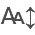


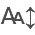

In [20]:
# User friendly output for final output
def format_2f(row):
    return '{:.2f}%'.format((row['word pct mod'] / row['word pct orig'] - 1.0) * 100 )

def style_it(styler):
    styler.hide()
    styler.set_table_styles([{'selector':'th', 'props':[('word-wrap', ' break-word'), ('max-width','25px'), ( 'text-align', 'right') ] }])
    styler.set_table_styles([{'selector': 'caption', 'props': 'font-size:1.25em; font-weight: bold;'}])
    styler.format(precision=3)
    styler.set_properties(**{'font-weight': 'bold'}, subset=['word'])
    return styler
    

presentable_df = top_1000_words_pct_df.copy()
presentable_df['word'] = presentable_df['word'].str[:30]

presentable_df = presentable_df.rename(columns ={'word count orig': 'count before', 'word count mod': 'count after', 'word pct orig': 'per article before',
       'word pct mod': 'per article after', '% relative change': '% change'})
presentable_df = presentable_df.sort_values(by='score',ascending=False)
presentable_df = presentable_df.loc[presentable_df['% change'].str.contains('\+'),['word','count before', 'count after','per article before','per article after','% change',]]
presentable_df = presentable_df.head(30)


init_notebook_mode(all_interactive=False)
display(presentable_df.style.pipe(style_it).set_caption(f"Spiked terms after ChatGPT edit ({basic_stats.loc[0,'url']} articles)"))
init_notebook_mode(all_interactive=True)



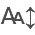


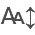

In [21]:

presentable_df = top_1000_words_pct_df.copy()
presentable_df['word'] = presentable_df['word'].str[:30]

presentable_df = presentable_df.rename(columns ={'word count orig': 'count before', 'word count mod': 'count after', 'word pct orig': 'per article before',
       'word pct mod': 'per article after', '% relative change': '% change'})
presentable_df = presentable_df.sort_values(by='score',ascending=False)
presentable_df = presentable_df.loc[presentable_df['% change'].str.contains('\-'),['word','count before', 'count after','per article before','per article after','% change']]
presentable_df = presentable_df.head(30)


init_notebook_mode(all_interactive=False)
display(presentable_df.style.pipe(style_it).set_caption(f"Dropped terms after ChatGPT edit ({basic_stats.loc[0,'url']} articles)"))
init_notebook_mode(all_interactive=True)



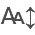


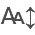

In [51]:
# Extra script for comparing the trend with chatGPT modified scripts word occurence. 
# Need the pickle output from trend analysis script

with open('top_1000_words_pct_df_trend.pkl', 'rb') as f:
    top_1000_words_pct_df_trend = pickle.load(f)

top_1000_words_pct_df_trend = top_1000_words_pct_df_trend.loc[:,['% relative change']].rename(columns={'% relative change':'% change 2022 vs 2023'})

combined_df = pd.merge(top_1000_words_pct_df,top_1000_words_pct_df_trend, on='word',how='left')

combined_df = combined_df.rename(columns ={'word count orig': 'count before', 'word count mod': 'count after', 'word pct orig': 'per article before',
       'word pct mod': 'per article after', '% relative change': '% change chatGPT'})
combined_df = combined_df.sort_values(by='score',ascending=False)
combined_df = combined_df.loc[combined_df['% change chatGPT'].str.contains('\+'),['word','% change chatGPT','% change 2022 vs 2023']]

init_notebook_mode(all_interactive=False)
display(combined_df.style.pipe(style_it).set_caption("Comparing % change of chatGPT edit & [2022 VS 2023]"))
init_notebook_mode(all_interactive=True)
